In [1]:
import numpy as np
import pandas as pd
import geopy.distance


In [2]:
def get_distance(coords1: tuple, coords2: tuple):
    return geopy.distance.geodesic(coords1, coords2).km

In [3]:
import os
os.system('pwd')

/home/rafael/private/ufrj/otimizacao-natural/tsp/tsp/notebooks


0

In [6]:
cities = pd.read_csv('../data/municipios.csv')
cities['codigo_ibge'] = cities['codigo_ibge'].astype(str)

In [7]:
import requests

response = requests.get('https://servicodados.ibge.gov.br/api/v3/agregados/6579/periodos/2024/variaveis/9324?localidades=N6[all]')

In [8]:
# explode all keys to columns from dicts inside localidade and serie columns
res_data = pd.DataFrame(response.json()[0]['resultados'][0]['series'])
res_data = res_data.join(pd.json_normalize(res_data['localidade'])).drop(columns=['localidade'])
res_data = res_data.join(pd.json_normalize(res_data['serie'])).drop(columns=['serie'])
res_data = res_data.rename(columns={'2024': 'populacao'})
# res_data

In [9]:
data = cities.merge(res_data, how='left', left_on='codigo_ibge', right_on='id', suffixes=('', '_estado')).sort_values(by='populacao', ascending=False)[['codigo_ibge', 'nome', 'populacao', 'nome_estado', 'latitude', 'longitude']]

In [10]:
data['populacao'] = data['populacao'].astype(int)

In [11]:
data['estado'] = data['nome_estado'].apply(lambda x: x.split(' ')[-1])
data = data.drop(columns=['nome_estado'])

In [12]:
data.sort_values(by=['estado', 'populacao'], ascending=False)

,codigo_ibge,nome,populacao,latitude,longitude,estado
3531,1721000,Palmas,323625,-10.24000,-48.3558,TO
314,1702109,Araguaína,181493,-7.19238,-48.2044,TO
2050,1709500,Gurupi,89574,-11.72790,-49.0680,TO
3970,1718204,Porto Nacional,68555,-10.70270,-48.4080,TO
3582,1716109,Paraíso do Tocantins,55164,-10.17500,-48.8823,TO
...,...,...,...,...,...,...
3980,1200393,Porto Walter,11275,-8.26323,-72.7537,AC
1082,1200179,Capixaba,10922,-10.56600,-67.6860,AC
2608,1200328,Jordão,9787,-9.19080,-71.9503,AC
410,1200054,Assis Brasil,8573,-10.92980,-69.5738,AC


In [25]:
import geodatasets
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
df = data.sort_values(by=['populacao'], ascending=False).head(30)[['nome', 'latitude', 'longitude', 'populacao', 'estado']]
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)

In [26]:
import geobr
brazil = geobr.read_state()

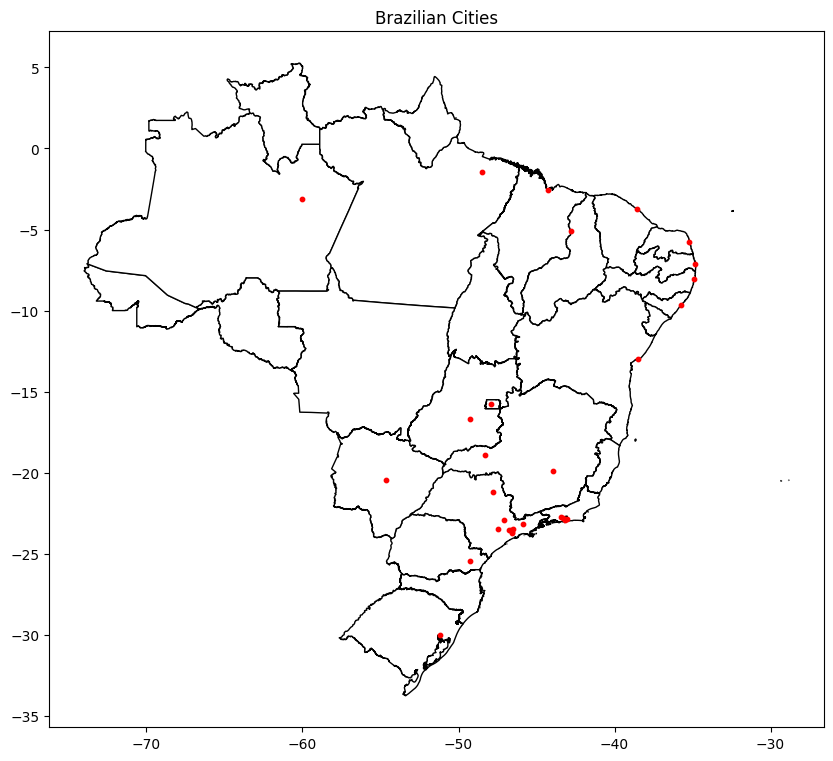

In [27]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
brazil.plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=ax, color='red', markersize=10) # Adjust markersize as needed
plt.title("Brazilian Cities")
plt.show()

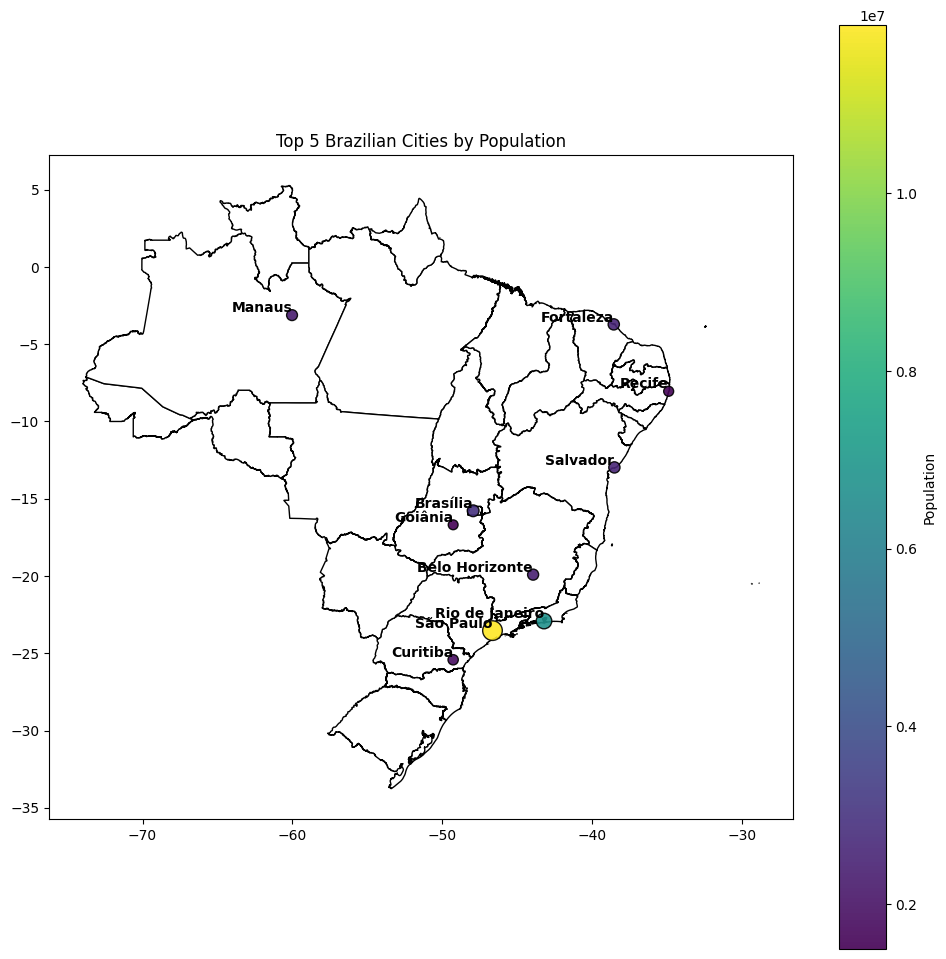

In [33]:
# Filter top 5 cities by population
top5 = gdf.sort_values(by='populacao', ascending=False).head(10)

# Normalize population for color and size mapping
norm = mcolors.Normalize(vmin=top5['populacao'].min(), vmax=top5['populacao'].max())
cmap = plt.cm.viridis

# Marker size proportional to population (adjust scale as needed)
sizes = 50 + 150 * (top5['populacao'] - top5['populacao'].min()) / (top5['populacao'].max() - top5['populacao'].min())

fig, ax = plt.subplots(figsize=(12, 12))
brazil.plot(ax=ax, color='white', edgecolor='black')

sc = ax.scatter(
    top5['longitude'], top5['latitude'],
    c=top5['populacao'], cmap=cmap, norm=norm, s=sizes, edgecolor='k', alpha=0.9
)

for _, row in top5.iterrows():
    ax.text(row['longitude'], row['latitude'], row['nome'], fontsize=10, ha='right', va='bottom', fontweight='bold')

plt.title("Top 5 Brazilian Cities by Population")
plt.colorbar(sc, ax=ax, label='Population')
plt.show()

In [70]:
def plot_tsp_solution(city_order, gdf, brazil, ax=None, title="TSP Solution for Brazilian Cities", show_names_only=False):
    """
    Plots the TSP solution on the Brazil map.

    Parameters:
        city_order (list): List of indices or city names in the visiting order.
        gdf (GeoDataFrame): GeoDataFrame with city info (must include 'longitude' and 'latitude').
        brazil (GeoDataFrame): GeoDataFrame with Brazil state boundaries.
        ax (matplotlib.axes.Axes, optional): Axis to plot on. If None, creates a new one.
        title (str): Title for the plot.
        show_names_only (bool): If True, only show city names in visiting order.
    """
    import matplotlib.pyplot as plt

    # Prepare coordinates in visiting order
    if isinstance(city_order[0], str):
        visited_gdf = gdf[gdf['nome'].isin(city_order)]
        coords = visited_gdf.set_index('nome').loc[city_order][['longitude', 'latitude']].values
        names = city_order
    else:
        visited_gdf = gdf.iloc[city_order]
        coords = visited_gdf[['longitude', 'latitude']].values
        names = visited_gdf['nome'].values

    # Optionally close the loop
    coords = np.vstack([coords, coords[0]])
    names = list(names) + [names[0]]

    if show_names_only:
        print("Visited cities in order:")
        for name in names[:-1]:
            print(name)
        return

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 12))
    brazil.plot(ax=ax, color='white', edgecolor='black')
    visited_gdf.plot(ax=ax, color='red', markersize=30, zorder=2)

    # Plot the TSP path
    ax.plot(coords[:, 0], coords[:, 1], color='black', linewidth=2, zorder=3, label='TSP Path')

    # Annotate cities
    for idx, (lon, lat) in enumerate(coords[:-1]):
        ax.text(lon, lat, names[idx], fontsize=9, ha='right', va='bottom')

    ax.set_title(title)
    ax.legend()
    plt.show()

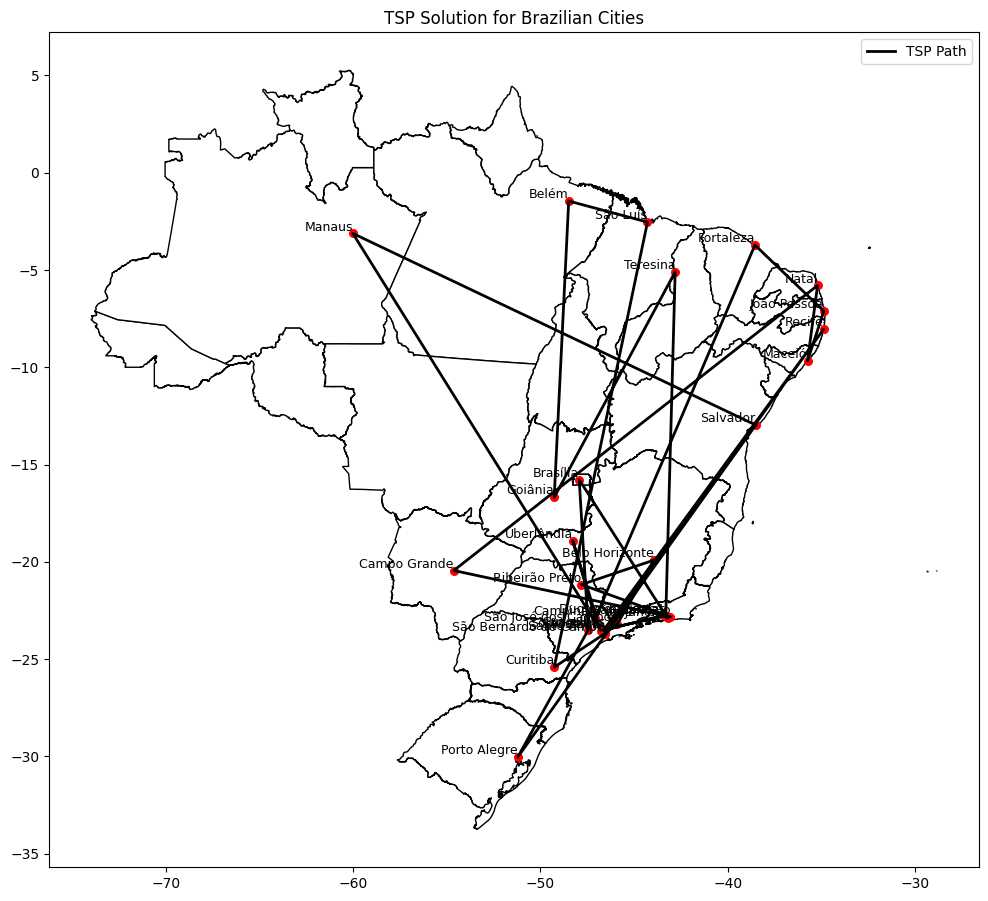

In [77]:
plot_tsp_solution(gdf.sample(n=30)['nome'].values, gdf, brazil)

In [76]:
gdf.shape

(30, 6)